In [3]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from genome import get_chromosome_lengths, parse_gff, get_chromosome_valid_genes
from utils import get_upstream_window_coordinates, get_gene_sequence

In [4]:
data_path = "../data/max_positions_log.csv"
fasta_path = "../data/genome/fasta_file.fsa"

In [5]:
FASTA_CHROMOSOME_RENAME_MAP = {
    "ref|NC_001133|": "chrI",
    "ref|NC_001134|": "chrII",
    "ref|NC_001135|": "chrIII",
    "ref|NC_001136|": "chrIV",
    "ref|NC_001137|": "chrV",
    "ref|NC_001138|": "chrVI",
    "ref|NC_001139|": "chrVII",
    "ref|NC_001140|": "chrVIII",
    "ref|NC_001141|": "chrIX",
    "ref|NC_001142|": "chrX",
    "ref|NC_001143|": "chrXI",
    "ref|NC_001144|": "chrXII",
    "ref|NC_001145|": "chrXIII",
    "ref|NC_001146|": "chrXIV",
    "ref|NC_001147|": "chrXV",
    "ref|NC_001148|": "chrXVI",
    "ref|NC_001224|": "chrM",
}

In [6]:

cds_coords = parse_gff("../data/genome/gff_file.gff")

In [7]:
cds_coords

defaultdict(dict,
            {'YAL069W': {'chromosome': 'chrI',
              'strand': '+',
              'coordinates': [(334, 649)]},
             'YAL068W-A': {'chromosome': 'chrI',
              'strand': '+',
              'coordinates': [(537, 792)]},
             'YAL068C': {'chromosome': 'chrI',
              'strand': '-',
              'coordinates': [(1806, 2169)]},
             'YAL067W-A': {'chromosome': 'chrI',
              'strand': '+',
              'coordinates': [(2479, 2707)]},
             'YAL067C': {'chromosome': 'chrI',
              'strand': '-',
              'coordinates': [(7234, 9016)]},
             'YAL066W': {'chromosome': 'chrI',
              'strand': '+',
              'coordinates': [(10090, 10399)]},
             'YAL065C': {'chromosome': 'chrI',
              'strand': '-',
              'coordinates': [(11564, 11951)]},
             'YAL064W-B': {'chromosome': 'chrI',
              'strand': '+',
              'coordinates': [(12045, 12426)]}

In [8]:
df = pd.read_csv(data_path)

In [9]:
df

,epoch,gene,condition,max_position,max_value
0,0,YCL076W,0,380,1.086000
1,0,YCL076W,1,413,0.958119
2,0,YCL076W,2,394,1.075750
3,0,YCL076W,3,445,0.947275
4,0,YCL076W,4,394,0.964787
...,...,...,...,...,...
66595,19,YCR095C,13,471,0.329858
66596,19,YCR095C,14,142,0.518556
66597,19,YCR095C,15,436,0.442107
66598,19,YCR095C,16,7,0.261903


In [10]:
 upstream_window_coordinates = get_upstream_window_coordinates(cds_coords['YAL068W-A'], 500)

In [11]:
 upstream_window_coordinates

(37, 537, '+')

In [12]:
gene_data = {
    'chromosome': 'chrI',
    'strand': '+',
    'coordinates': [(37, 537)]
}

seq = get_gene_sequence(gene_data,fasta_path , rename_map=FASTA_CHROMOSOME_RENAME_MAP)
print(seq)
print(len(seq))

ACCACACCACACCCACACACACACATCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTTACTACCACTCACCCACCGTTACCCTCCAATTACCCATATCCAACCCACTGCCACTTACCCTACCATTACCCTACCATCCACCATGACCTACTCACCATACTGTTCTTCTACCCACCATATTGAAACGCTAACAAATGATCGTAAATAACACACACGTGCTTACCCTACCACTTTATACCACCACCACATGCCATACTCACCCTCACTTGTATACTGATTTTACGTACGCACACGGATGCTACAGTATATACCATCTCAAACTTACCCTACTCTCAGATTCCACTTCACTCCATGGCCCATCTCTCACTGAATCAGTACCAAATGCACTCACATCATT
500


In [13]:
def get_snippet_around_position(seq, position, window):
    start = max(position - window, 0)
    end = min(position + window, len(seq))
    return seq[start:end]


In [14]:
def extract_snippets_from_upstream(
    df, 
    cds_coords, 
    fasta_path, 
    rename_map, 
    upstream_window=500, 
    motif_window=20
):
    """
    Adds a 'snippet' column to the DataFrame containing sequences around max_position
    from the upstream region of each gene.

    Args:
        df (pd.DataFrame): DataFrame with columns 'gene' and 'max_position'.
        cds_coords (dict): Dict mapping gene -> {'chromosome', 'strand', 'coordinates'}.
        fasta_path (str): Path to the genome FASTA file.
        rename_map (dict): Mapping from FASTA record IDs to chromosome names.
        upstream_window (int): Length of upstream region to extract.
        motif_window (int): Half-width of the motif snippet (total length = 2*motif_window).

    Returns:
        pd.DataFrame: Modified DataFrame with added 'snippet' column.
    """
    for gene in df.gene.unique():
        if gene not in cds_coords:
            continue

        upstream_window_coordinates = get_upstream_window_coordinates(cds_coords[gene], upstream_window)
        
        gene_data = {
            'chromosome': cds_coords[gene]["chromosome"],
            'strand': cds_coords[gene]["strand"],
            'coordinates': [(upstream_window_coordinates[0], upstream_window_coordinates[1])]
        }

        seq = get_gene_sequence(gene_data, fasta_path, rename_map=rename_map)

        for idx, row in df[df.gene == gene].iterrows():
            snippet = get_snippet_around_position(seq, row["max_position"], motif_window)
            df.at[idx, "snippet"] = snippet

    return df

In [15]:
df["snippet"]= ""

In [16]:
df = extract_snippets_from_upstream(df, cds_coords, fasta_path, FASTA_CHROMOSOME_RENAME_MAP)


In [17]:
df

,epoch,gene,condition,max_position,max_value,snippet
0,0,YCL076W,0,380,1.086000,TTTAGACAAGGAGAACATATAGTAGCAAACCTCTAATCCG
1,0,YCL076W,1,413,0.958119,TAATCCGGTAGTACTTAAGAAACTACAGTTTCTATGTACG
2,0,YCL076W,2,394,1.075750,ACATATAGTAGCAAACCTCTAATCCGGTAGTACTTAAGAA
3,0,YCL076W,3,445,0.947275,TATGTACGAAAGCAGTAACTATGTAATTATTACATTTACA
4,0,YCL076W,4,394,0.964787,ACATATAGTAGCAAACCTCTAATCCGGTAGTACTTAAGAA
...,...,...,...,...,...,...
66595,19,YCR095C,13,471,0.329858,AAAAGAGAGACACTTACAGCACTGGTGCGATCCATAACCT
66596,19,YCR095C,14,142,0.518556,AGAAGCCCAATGCTCAAGCTTTGAATATCATATTTTAAAA
66597,19,YCR095C,15,436,0.442107,ATGAGATGTGGTTGTTATATGGAGATCGTAGAATAAAAAG
66598,19,YCR095C,16,7,0.261903,ACTTTTTTTATTTACTTTCGTATGTTC


<Axes: xlabel='max_position', ylabel='Count'>

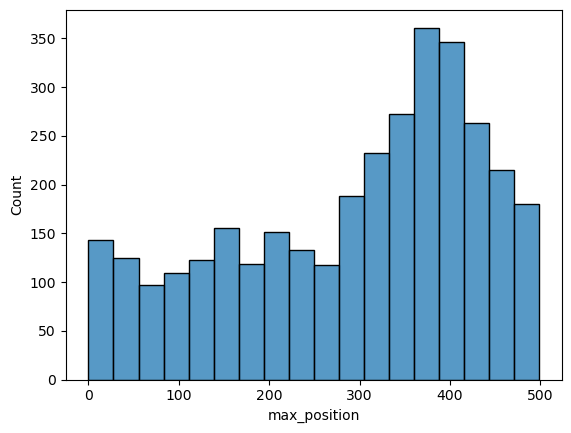

In [33]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

def plot_epoch_evolution(df, bins=50, n_plots=5):
    epochs = sorted(df["epoch"].unique())
    selected_epochs = np.linspace(0, max(epochs), n_plots, dtype=int)

    fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 4, 3), sharex=True, sharey=True)

    for i, epoch in enumerate(selected_epochs):
        ax = axes[i]
        sb.histplot(df[df.epoch == epoch]["max_position"], bins=bins, ax=ax)
        ax.set_title(f"Epoch {epoch}")
        ax.set_xlabel("")

    axes[0].set_ylabel("Count")
    plt.tight_layout()
    plt.show()


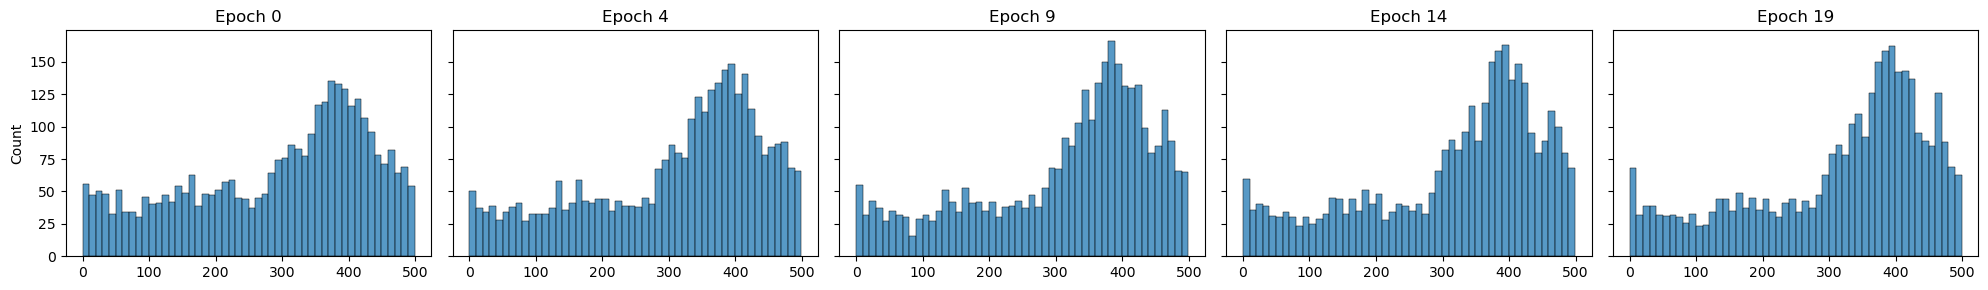

In [35]:
plot_epoch_evolution(df)


In [41]:
conditions_names = pd.read_csv("../data/condition.csv")

In [42]:
conditions_names

,condition,desc,samples
0,exponential growth,YPAD medium,"K01sl,K02sl,K01sl_2"
1,salt,1M salt for 45 minutes,"K03sl,K04sl"
2,DNA damage,1mM MMS for 1 hour,"K05sl,K06sl"
3,alpha factor,2.5mM for 45 minutes; add another 50µL to 25mL...,"K07sl,K08sl"
4,sorbitol,1M sorbitol for 45 minutes,"K09sl,K10sl"
5,oxidative stress,0.4M H2O2 for 45 minutes,"K11sl,K12sl"
6,heat shock,in 37°C shaker for 1 hour,"K13sl,K14sl"
7,stationary phase,18 days in 30°C incubator,"K15sl,K16sl"
8,sc. media,synthetic complete medium,"K17sl,K18sl"
9,sc glycerol media,4% glycerol instead of glucose in sc medium,"K19sl,K20sl"


In [49]:
def map_condition_indices_to_names(df, conditions_df):
    condition_map = conditions_df["condition"].to_dict()
    df["condition_name"] = df["condition"].map(condition_map)
    return df


In [51]:
# Assuming `df` has a 'sample' column and your condition info is in `conditions_df`
df = map_condition_indices_to_names(df, conditions_names)


In [67]:
import matplotlib.pyplot as plt
import seaborn as sb

def plot_first_last_per_condition(df, bins=50):
    conditions = df["condition_name"].unique()
    max_epoch = df["epoch"].max()

    n_conditions = len(conditions)
    fig, axes = plt.subplots(n_conditions, 2, figsize=(10, 3 * n_conditions), sharex=False, sharey=True)

    if n_conditions == 1:
        axes = axes.reshape(1, 2)  # handle single-condition case

    for i, condition in enumerate(conditions):
        for j, epoch in enumerate([0, max_epoch]):
            ax = axes[i, j]
            data = df[(df["condition_name"] == condition) & (df["epoch"] == epoch)]["max_position"]
            sb.histplot(data, bins=bins, ax=ax)
            ax.set_title(f"Condition {condition} — Epoch {epoch}")
            ax.set_xlabel("max_position")
            if j == 0:
                ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


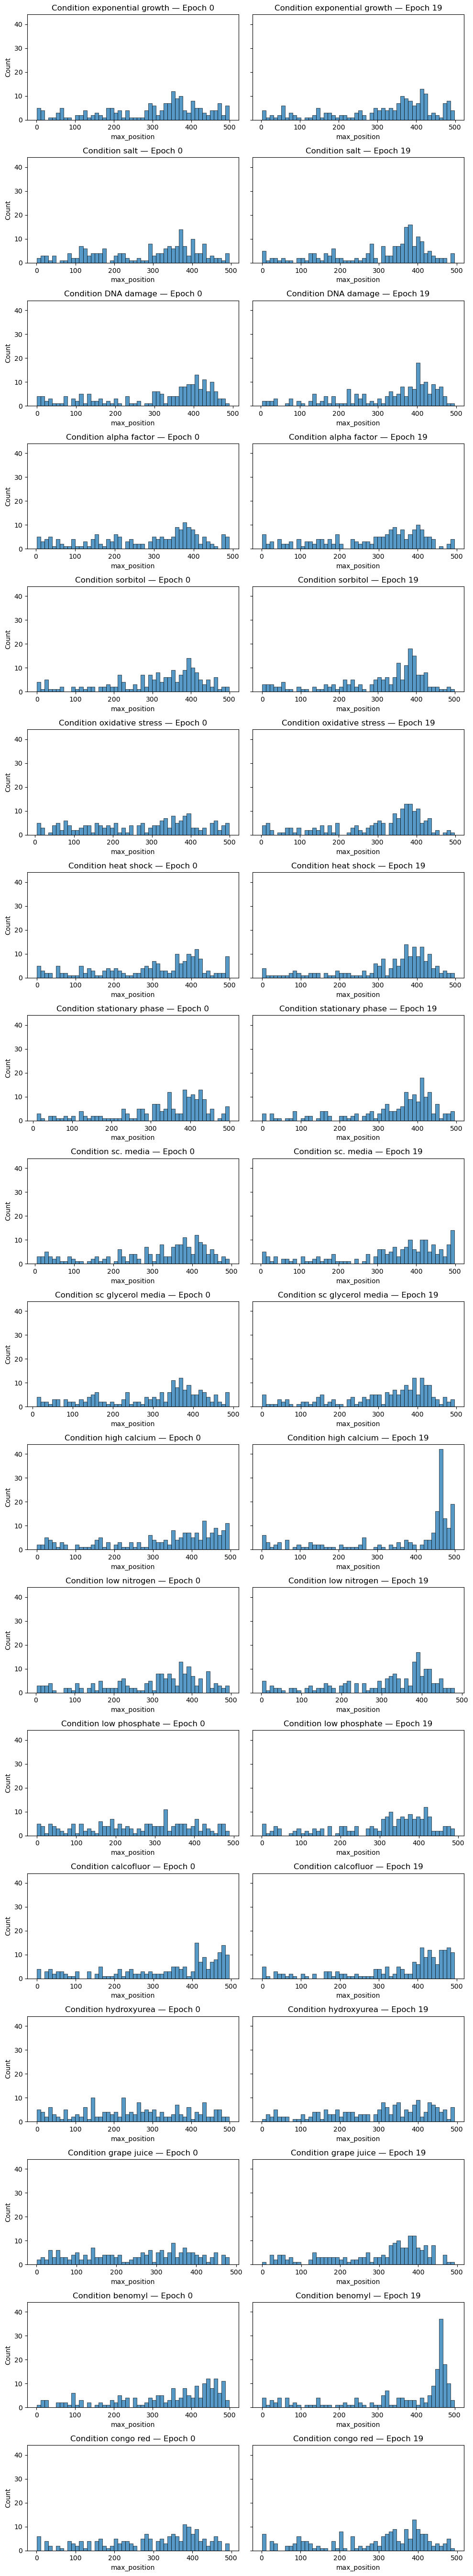

In [68]:
plot_first_last_per_condition(df)


In [63]:
from scipy.stats import mode

subset = df[(df.epoch == 19) & (df.condition_name == "high calcium")]["max_position"]
most_common = mode(subset, keepdims=False)
print(most_common)


ModeResult(mode=np.int64(496), count=np.int64(10))


In [86]:
df_filtered = df[(df.epoch==19) & (df.condition_name== "high calcium") & df.max_position.isin(range(most_common.mode-20,most_common.mode+20))]

In [87]:
df_filtered

,epoch,gene,condition,max_position,max_value,snippet,condition_name
63730,19,YCL047C,10,499,0.240307,TACGTGCACTAGCAGACTAAT,high calcium
63748,19,YCL045C,10,478,0.563777,ACATTCATATCAACACTTTCATCCTCCCCTTCCCCCATAG,high calcium
63766,19,YCL046W,10,483,1.458506,TGCGTTATGGTCATTACTATCCAGTTGAATCTCATCA,high calcium
63838,19,YCL042W,10,496,0.801682,CGGGAAATAACAATAACGACAAAA,high calcium
63856,19,YCL040W,10,484,1.200213,CAACACCACCACTAATACAACTCTATCATACACAAG,high calcium
63946,19,YCL035C,10,487,0.323010,ATACAAATAGACAAAACCTCAGAAGGAAAAAAA,high calcium
63964,19,YCL034W,10,496,0.421143,ATTGGAGGCAGGCAAAACAAGAAC,high calcium
64018,19,YCL031C,10,483,0.671667,AGGTAACAGATAACAACCTCAGATAGAGTGTTACGGG,high calcium
64162,19,YCL023C,10,496,0.758331,TGAGATTACTTTGACGGCTGTTCT,high calcium
64306,19,YCL016C,10,479,1.329295,TAAAAATCCACCAGAGATTTGCTCACTAATAATCCTGTAC,high calcium


In [88]:
def write_snippets_fasta(df, path="snippets.fasta"):
    with open(path, "w") as f:
        for i, row in df.iterrows():
            f.write(f">seq_{i}_{row['gene']}\n")
            f.write(f"{row['snippet']}\n")


In [89]:
write_snippets_fasta(df_filtered, path="snippets.fasta")